# Sentiment Analysis with GoodText Reviews

The Goal of the experiment is to be able to create a neural network which is able to say what rating a book got based only on the text of the review. However, due to the fact that it may be difficult to assign an appropriate rating when reviews for 2 and 3 star books may sound similar. As such, in the second part of the experiment only a positive/negative classification will be expected from the model with positive including 3, 4 and 5 stars and negative including 0, 1, 2.

In [3]:
!pip install -q -U tf-models-official==2.7.0
!pip3 install --quiet tensorflow-text
!pip install -q -U "tensorflow-text==2.8.*"

     |████████████████████████████████| 1.8 MB 7.4 MB/s 
     |████████████████████████████████| 116 kB 64.7 MB/s 
     |████████████████████████████████| 99 kB 9.8 MB/s 
     |████████████████████████████████| 596 kB 53.7 MB/s 
     |████████████████████████████████| 238 kB 69.6 MB/s 
     |████████████████████████████████| 43 kB 2.3 MB/s 
     |████████████████████████████████| 4.6 MB 48.6 MB/s 
     |████████████████████████████████| 1.3 MB 48.7 MB/s 
     |████████████████████████████████| 1.1 MB 61.4 MB/s 
     |████████████████████████████████| 352 kB 70.9 MB/s 
     |████████████████████████████████| 511.7 MB 5.5 kB/s 
     |████████████████████████████████| 511.7 MB 4.6 kB/s 
     |████████████████████████████████| 4.9 MB 56.2 MB/s 


# Multi-Class Sentiment Analysis

### Data Import and Analysis

In [4]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential
import tensorflow_text as text
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
from official.nlp import optimization
import shutil
import random
import numpy as np
import pandas as pd
import tensorflow_hub as hub
import tensorflow_datasets as tfds
tf.get_logger().setLevel('ERROR')

In [5]:
reviews_df=pd.read_csv("/content/drive/MyDrive/GoodReviews_NN/goodreads_train.csv")

In [6]:
reviews_df

,user_id,book_id,review_id,rating,review_text,date_added,date_updated,read_at,started_at,n_votes,n_comments
0,8842281e1d1347389f2ab93d60773d4d,18245960,dfdbb7b0eb5a7e4c26d59a937e2e5feb,5,This is a special book. It started slow for ab...,Sun Jul 30 07:44:10 -0700 2017,Wed Aug 30 00:00:26 -0700 2017,Sat Aug 26 12:05:52 -0700 2017,Tue Aug 15 13:23:18 -0700 2017,28,1
1,8842281e1d1347389f2ab93d60773d4d,16981,a5d2c3628987712d0e05c4f90798eb67,3,Recommended by Don Katz. Avail for free in Dec...,Mon Dec 05 10:46:44 -0800 2016,Wed Mar 22 11:37:04 -0700 2017,NaN,NaN,1,0
2,8842281e1d1347389f2ab93d60773d4d,28684704,2ede853b14dc4583f96cf5d120af636f,3,"A fun, fast paced science fiction thriller. I ...",Tue Nov 15 11:29:22 -0800 2016,Mon Mar 20 23:40:27 -0700 2017,Sat Mar 18 23:22:42 -0700 2017,Fri Mar 17 23:45:40 -0700 2017,22,0
3,8842281e1d1347389f2ab93d60773d4d,27161156,ced5675e55cd9d38a524743f5c40996e,0,Recommended reading to understand what is goin...,Wed Nov 09 17:37:04 -0800 2016,Wed Nov 09 17:38:20 -0800 2016,NaN,NaN,5,1
4,8842281e1d1347389f2ab93d60773d4d,25884323,332732725863131279a8e345b63ac33e,4,"I really enjoyed this book, and there is a lot...",Mon Apr 25 09:31:23 -0700 2016,Mon Apr 25 09:31:23 -0700 2016,Sun Jun 26 00:00:00 -0700 2016,Sat May 28 00:00:00 -0700 2016,9,1
...,...,...,...,...,...,...,...,...,...,...,...
899995,b9450d1c1f97f891c392b1105959b56e,11832081,7c34c15ad8cb28a4afca32946e2016ea,3,3.5 stars. \n Jenna is a popular YA author and...,Fri Nov 16 22:10:17 -0800 2012,Sat Nov 17 22:42:44 -0800 2012,Sat Nov 17 00:00:00 -0800 2012,Fri Nov 16 00:00:00 -0800 2012,0,0
899996,b9450d1c1f97f891c392b1105959b56e,16095092,e979c735276431915d089cfaf446d64f,3,This was a quick read for me. I have read a lo...,Fri Nov 16 22:09:49 -0800 2012,Sat Nov 17 23:38:58 -0800 2012,Sat Nov 17 00:00:00 -0800 2012,Fri Nov 16 00:00:00 -0800 2012,1,1
899997,b9450d1c1f97f891c392b1105959b56e,8430896,feb9fe6439f9fbba8a1cce36020ad977,4,** spoiler alert ** \n 3.5 stars. \n This book...,Tue Nov 13 05:38:24 -0800 2012,Tue Nov 13 23:29:17 -0800 2012,Tue Nov 13 00:00:00 -0800 2012,Tue Nov 13 00:00:00 -0800 2012,1,0
899998,b9450d1c1f97f891c392b1105959b56e,12275680,741e29369f70531bfffbd02add86f228,4,** spoiler alert ** \n Another fun read from M...,Mon Nov 12 05:42:30 -0800 2012,Tue Nov 13 22:32:05 -0800 2012,Tue Nov 13 00:00:00 -0800 2012,Mon Nov 12 00:00:00 -0800 2012,0,0


In [7]:
text_df=reviews_df["review_text"]

In [8]:
stars_df=reviews_df["rating"]

In [9]:
temp_df=pd.DataFrame()
temp_df["stars"]=stars_df
stars_df=temp_df
stars_df

,stars
0,5
1,3
2,3
3,0
4,4
...,...
899995,3
899996,3
899997,4
899998,4


In [10]:
encoder=OneHotEncoder()
stars_df = pd.DataFrame(encoder.fit_transform(stars_df[['stars']]).toarray())

In [11]:
stars_df

,0,1,2,3,4,5
0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...
899995,0.0,0.0,0.0,1.0,0.0,0.0
899996,0.0,0.0,0.0,1.0,0.0,0.0
899997,0.0,0.0,0.0,0.0,1.0,0.0
899998,0.0,0.0,0.0,0.0,1.0,0.0


In [12]:
text_df[random.randint(0,100)]

"What a fun series. I loved Wool, and Dust and Shift both gave us the backstory to explain the world and how it ended up. I think the first book was by far the best, but this gave us a nice conclusion. \n (view spoiler)[It was the conclusion we wanted to see - the people finally get outside! My problem with this book is there were lots of holes. A lot of the other reviews have pointed this out too, and I'm not sure if the fact I know it was self-published is biasing me to say it could have used more editing, but feels that way a little. But the writing was great. \n There were lots of things that weren't cleared up or never really fully made sense. The major one is why Thurman really felt the need to destroy the whole world - feels like there could have been a lot more to that. It also wasn't clear how he really accomplished that - was it all nuclear or was it nano? If nuclear, wouldn't the world really be a wasteland? \n Whatever happened to silo 40 and other silo's that went dark? I 

In [13]:
text_df_10=text_df[:90000]
stars_df_10=stars_df[:90000]

In [14]:
temp_df=temp_df["stars"]

In [17]:
reviews_df["rating"]

0         5
1         3
2         3
3         0
4         4
         ..
899995    3
899996    3
899997    4
899998    4
899999    3
Name: rating, Length: 900000, dtype: int64

### Applying Models Through Transfer Learning

#### Base Model 1

In [ ]:
early_callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=3)

In [ ]:
base_model_1 = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(base_model_1, input_shape=[], dtype=tf.string, trainable=True)

In [ ]:
model_1 = tf.keras.Sequential()
model_1.add(hub_layer)
model_1.add(tf.keras.layers.Dense(64, activation='relu'))
model_1.add(tf.keras.layers.Dense(16, activation='relu'))
model_1.add(tf.keras.layers.Dense(6,activation="softmax"))
model_1.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_3 (KerasLayer)  (None, 50)                48190600  
                                                                 
 dense_9 (Dense)             (None, 64)                3264      
                                                                 
 dense_10 (Dense)            (None, 16)                1040      
                                                                 
 dense_11 (Dense)            (None, 6)                 102       
                                                                 
Total params: 48,195,006
Trainable params: 48,195,006
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.losses.CategoricalCrossentropy(from_logits=True),
              metrics=["accuracy"])

In [ ]:
x_train=text_df_10[:75000]
y_train=stars_df_10[:75000]
x_val=text_df_10[75000:90000]
y_val=stars_df_10[75000:90000]
history_1 = model_1.fit(x_train,
                    y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1,
                    callbacks=[early_callback])

Epoch 1/40
147/147 [==============================] - 87s 587ms/step - loss: 1.6470 - accuracy: 0.3481 - val_loss: 1.5954 - val_accuracy: 0.3653
Epoch 2/40
147/147 [==============================] - 86s 582ms/step - loss: 1.5576 - accuracy: 0.3512 - val_loss: 1.4739 - val_accuracy: 0.3675
Epoch 3/40
147/147 [==============================] - 84s 569ms/step - loss: 1.4646 - accuracy: 0.3606 - val_loss: 1.4099 - val_accuracy: 0.3885
Epoch 4/40
147/147 [==============================] - 84s 575ms/step - loss: 1.3940 - accuracy: 0.4143 - val_loss: 1.3467 - val_accuracy: 0.4299
Epoch 5/40
147/147 [==============================] - 83s 564ms/step - loss: 1.3254 - accuracy: 0.4563 - val_loss: 1.2891 - val_accuracy: 0.4537
Epoch 6/40
147/147 [==============================] - 83s 567ms/step - loss: 1.2605 - accuracy: 0.4784 - val_loss: 1.2441 - val_accuracy: 0.4665
Epoch 7/40
147/147 [==============================] - 83s 568ms/step - loss: 1.2106 - accuracy: 0.4941 - val_loss: 1.2120 - val_ac

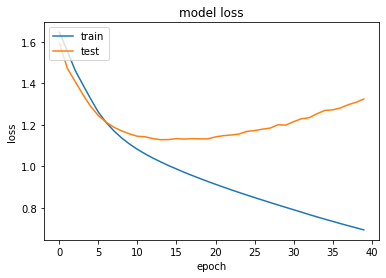

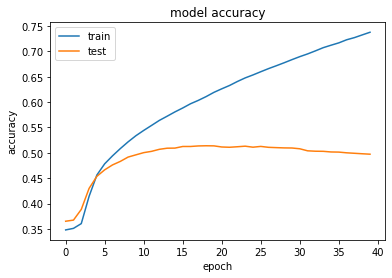

In [ ]:
plt.plot(history_1.history['loss'])
plt.plot(history_1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### Base Model 2

In [ ]:
early_callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=3)

In [ ]:
base_model_2 = "https://tfhub.dev/google/nnlm-en-dim50-with-normalization/2"
hub_layer = hub.KerasLayer(base_model_2, input_shape=[], dtype=tf.string, trainable=True)

In [ ]:
model_2 = tf.keras.Sequential()
model_2.add(hub_layer)
model_2.add(tf.keras.layers.Dense(64, activation='relu'))
model_2.add(tf.keras.layers.Dense(16, activation='relu'))
model_2.add(tf.keras.layers.Dense(6,activation="softmax"))
model_2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_4 (KerasLayer)  (None, 50)                48190600  
                                                                 
 dense_12 (Dense)            (None, 64)                3264      
                                                                 
 dense_13 (Dense)            (None, 16)                1040      
                                                                 
 dense_14 (Dense)            (None, 6)                 102       
                                                                 
Total params: 48,195,006
Trainable params: 48,195,006
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.losses.CategoricalCrossentropy(from_logits=True),
              metrics=["accuracy"])

In [ ]:
x_train=text_df_10[:75000]
y_train=stars_df_10[:75000]
x_val=text_df_10[75000:90000]
y_val=stars_df_10[75000:90000]
history_2 = model_2.fit(x_train,
                    y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1,
                    callbacks=[early_callback])

Epoch 1/40


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


147/147 [==============================] - ETA: 0s - loss: 1.6405 - accuracy: 0.3455

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


147/147 [==============================] - 104s 697ms/step - loss: 1.6405 - accuracy: 0.3455 - val_loss: 1.5077 - val_accuracy: 0.3656
Epoch 2/40
147/147 [==============================] - 104s 706ms/step - loss: 1.4754 - accuracy: 0.3740 - val_loss: 1.4190 - val_accuracy: 0.3917
Epoch 3/40
147/147 [==============================] - 105s 712ms/step - loss: 1.4099 - accuracy: 0.4113 - val_loss: 1.3628 - val_accuracy: 0.4221
Epoch 4/40
147/147 [==============================] - 95s 644ms/step - loss: 1.3518 - accuracy: 0.4445 - val_loss: 1.3109 - val_accuracy: 0.4458
Epoch 5/40
147/147 [==============================] - 86s 584ms/step - loss: 1.2969 - accuracy: 0.4671 - val_loss: 1.2684 - val_accuracy: 0.4620
Epoch 6/40
147/147 [==============================] - 86s 583ms/step - loss: 1.2484 - accuracy: 0.4857 - val_loss: 1.2329 - val_accuracy: 0.4737
Epoch 7/40
147/147 [==============================] - 86s 587ms/step - loss: 1.2055 - accuracy: 0.5015 - val_loss: 1.2053 - val_accuracy: 

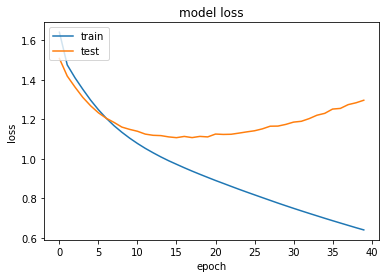

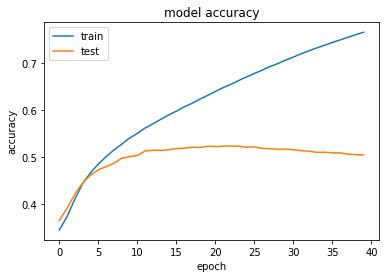

In [ ]:
plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.plot(history_2.history['accuracy'])
plt.plot(history_2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### Base Model 3

In [ ]:
early_callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=3)

In [ ]:
base_model_3 = "https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2"
hub_layer = hub.KerasLayer(base_model_3, input_shape=[], dtype=tf.string, trainable=True)

In [ ]:
model_3 = tf.keras.Sequential()
model_3.add(hub_layer)
model_3.add(tf.keras.layers.Dense(64, activation='relu'))
model_3.add(tf.keras.layers.Dense(16, activation='relu'))
model_3.add(tf.keras.layers.Dense(6,activation="softmax"))
model_3.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_5 (KerasLayer)  (None, 128)               124642688 
                                                                 
 dense_15 (Dense)            (None, 64)                8256      
                                                                 
 dense_16 (Dense)            (None, 16)                1040      
                                                                 
 dense_17 (Dense)            (None, 6)                 102       
                                                                 
Total params: 124,652,086
Trainable params: 124,652,086
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.losses.CategoricalCrossentropy(from_logits=True),
              metrics=["accuracy"])

In [ ]:
x_train=text_df_10[:75000]
y_train=stars_df_10[:75000]
x_val=text_df_10[75000:90000]
y_val=stars_df_10[75000:90000]
history_3 = model_3.fit(x_train,
                    y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1,
                    callbacks=[early_callback])

Epoch 1/40


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


147/147 [==============================] - ETA: 0s - loss: 1.6616 - accuracy: 0.3372

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


147/147 [==============================] - 219s 1s/step - loss: 1.6616 - accuracy: 0.3372 - val_loss: 1.5004 - val_accuracy: 0.4107
Epoch 2/40
147/147 [==============================] - 209s 1s/step - loss: 1.4516 - accuracy: 0.4259 - val_loss: 1.3725 - val_accuracy: 0.4313
Epoch 3/40
147/147 [==============================] - 209s 1s/step - loss: 1.3461 - accuracy: 0.4525 - val_loss: 1.2972 - val_accuracy: 0.4509
Epoch 4/40
147/147 [==============================] - 212s 1s/step - loss: 1.2685 - accuracy: 0.4822 - val_loss: 1.2423 - val_accuracy: 0.4737
Epoch 5/40
147/147 [==============================] - 212s 1s/step - loss: 1.2062 - accuracy: 0.5096 - val_loss: 1.2041 - val_accuracy: 0.4872
Epoch 6/40
147/147 [==============================] - 213s 1s/step - loss: 1.1471 - accuracy: 0.5323 - val_loss: 1.1639 - val_accuracy: 0.4981
Epoch 7/40
147/147 [==============================] - 212s 1s/step - loss: 1.0861 - accuracy: 0.5513 - val_loss: 1.1347 - val_accuracy: 0.5045
Epoch 8/40

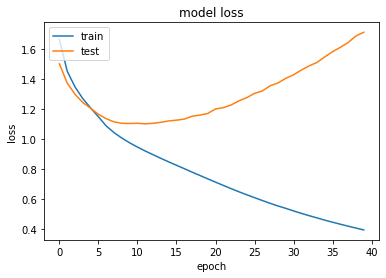

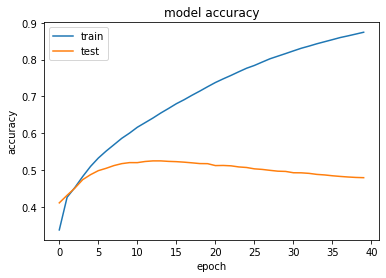

In [ ]:
plt.plot(history_3.history['loss'])
plt.plot(history_3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.plot(history_3.history['accuracy'])
plt.plot(history_3.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Fine-Tuning The Best Model

#### Attempt 1

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


147/147 [==============================] - ETA: 0s - loss: 1.6592 - accuracy: 0.3204

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


147/147 [==============================] - 210s 1s/step - loss: 1.6592 - accuracy: 0.3204 - val_loss: 1.5239 - val_accuracy: 0.3651
Epoch 2/20
147/147 [==============================] - 205s 1s/step - loss: 1.4947 - accuracy: 0.3691 - val_loss: 1.4242 - val_accuracy: 0.4041
Epoch 3/20
147/147 [==============================] - 205s 1s/step - loss: 1.4140 - accuracy: 0.4335 - val_loss: 1.3626 - val_accuracy: 0.4409
Epoch 4/20
147/147 [==============================] - 206s 1s/step - loss: 1.3451 - accuracy: 0.4762 - val_loss: 1.3028 - val_accuracy: 0.4683
Epoch 5/20
147/147 [==============================] - 205s 1s/step - loss: 1.2819 - accuracy: 0.5020 - val_loss: 1.2551 - val_accuracy: 0.4847
Epoch 6/20
147/147 [==============================] - 206s 1s/step - loss: 1.2266 - accuracy: 0.5195 - val_loss: 1.2158 - val_accuracy: 0.4916
Epoch 7/20
147/147 [==============================] - 206s 1s/step - loss: 1.1787 - accuracy: 0.5319 - val_loss: 1.1837 - val_accuracy: 0.4989
Epoch 8/20

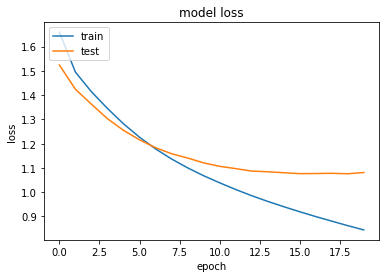

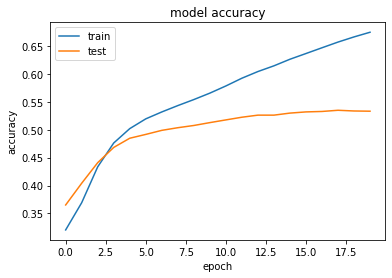

In [ ]:
early_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
base_model_3_1 = "https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2"
hub_layer = hub.KerasLayer(base_model_3_1, input_shape=[], dtype=tf.string, trainable=True)
model_3_1 = tf.keras.Sequential()
model_3_1.add(hub_layer)
model_3_1.add(tf.keras.layers.Dense(16, activation='relu'))
model_3_1.add(tf.keras.layers.Dense(6,activation="softmax"))
model_3_1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.losses.CategoricalCrossentropy(from_logits=True),
              metrics=["accuracy"])
x_train=text_df_10[:75000]
y_train=stars_df_10[:75000]
x_val=text_df_10[75000:90000]
y_val=stars_df_10[75000:90000]
history_3_1 = model_3_1.fit(x_train,
                    y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1,
                    callbacks=[early_callback])
plt.plot(history_3_1.history['loss'])
plt.plot(history_3_1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.plot(history_3_1.history['accuracy'])
plt.plot(history_3_1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### Attempt 2

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


147/147 [==============================] - ETA: 0s - loss: 1.5584 - accuracy: 0.3560

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


147/147 [==============================] - 204s 1s/step - loss: 1.5584 - accuracy: 0.3560 - val_loss: 1.4501 - val_accuracy: 0.3957
Epoch 2/20
147/147 [==============================] - 202s 1s/step - loss: 1.4204 - accuracy: 0.4220 - val_loss: 1.3499 - val_accuracy: 0.4517
Epoch 3/20
147/147 [==============================] - 202s 1s/step - loss: 1.3187 - accuracy: 0.4692 - val_loss: 1.2653 - val_accuracy: 0.4737
Epoch 4/20
147/147 [==============================] - 202s 1s/step - loss: 1.2365 - accuracy: 0.4975 - val_loss: 1.2110 - val_accuracy: 0.4844
Epoch 5/20
147/147 [==============================] - 202s 1s/step - loss: 1.1735 - accuracy: 0.5176 - val_loss: 1.1781 - val_accuracy: 0.4938
Epoch 6/20
147/147 [==============================] - 202s 1s/step - loss: 1.1245 - accuracy: 0.5360 - val_loss: 1.1516 - val_accuracy: 0.5015
Epoch 7/20
147/147 [==============================] - 201s 1s/step - loss: 1.0821 - accuracy: 0.5522 - val_loss: 1.1329 - val_accuracy: 0.5093
Epoch 8/20

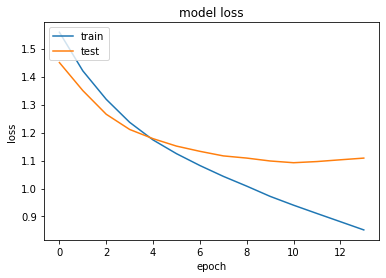

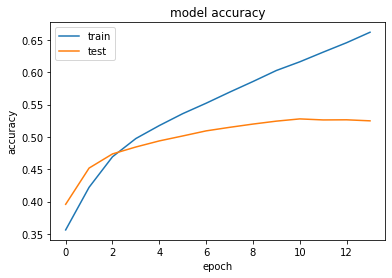

In [ ]:
early_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
base_model_3_2 = "https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2"
hub_layer = hub.KerasLayer(base_model_3_2, input_shape=[], dtype=tf.string, trainable=True)
model_3_2 = tf.keras.Sequential()
model_3_2.add(hub_layer)
model_3_2.add(tf.keras.layers.Dense(64, activation='tanh'))
model_3_2.add(tf.keras.layers.Dense(16, activation='relu'))
model_3_2.add(tf.keras.layers.Dense(6,activation="softmax"))
model_3_2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.losses.CategoricalCrossentropy(from_logits=True),
              metrics=["accuracy"])
x_train=text_df_10[:75000]
y_train=stars_df_10[:75000]
x_val=text_df_10[75000:90000]
y_val=stars_df_10[75000:90000]
history_3_2 = model_3_2.fit(x_train,
                    y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1,
                    callbacks=[early_callback])
plt.plot(history_3_2.history['loss'])
plt.plot(history_3_2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.plot(history_3_2.history['accuracy'])
plt.plot(history_3_2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### Attemp 3

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


147/147 [==============================] - ETA: 0s - loss: 1.6147 - accuracy: 0.2712

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


147/147 [==============================] - 306s 2s/step - loss: 1.6147 - accuracy: 0.2712 - val_loss: 1.4653 - val_accuracy: 0.3016
Epoch 2/20
147/147 [==============================] - 292s 2s/step - loss: 1.4059 - accuracy: 0.4008 - val_loss: 1.3089 - val_accuracy: 0.4507
Epoch 3/20
147/147 [==============================] - 296s 2s/step - loss: 1.2690 - accuracy: 0.4748 - val_loss: 1.2167 - val_accuracy: 0.4739
Epoch 4/20
147/147 [==============================] - 297s 2s/step - loss: 1.1798 - accuracy: 0.5064 - val_loss: 1.1669 - val_accuracy: 0.4863
Epoch 5/20
147/147 [==============================] - 293s 2s/step - loss: 1.1101 - accuracy: 0.5317 - val_loss: 1.1305 - val_accuracy: 0.4981
Epoch 6/20
147/147 [==============================] - 291s 2s/step - loss: 1.0518 - accuracy: 0.5548 - val_loss: 1.1033 - val_accuracy: 0.5100
Epoch 7/20
147/147 [==============================] - 293s 2s/step - loss: 1.0026 - accuracy: 0.5785 - val_loss: 1.0960 - val_accuracy: 0.5165
Epoch 8/20

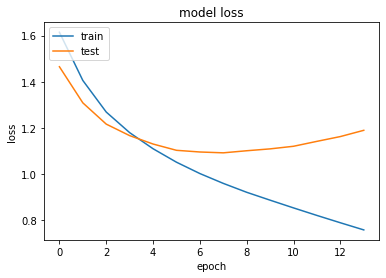

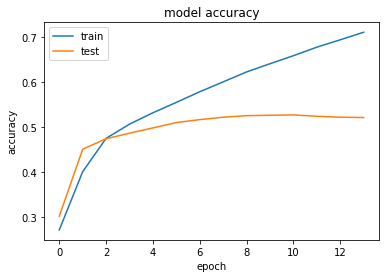

In [ ]:
early_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
base_model_3_3 = "https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2"
hub_layer = hub.KerasLayer(base_model_3_3, input_shape=[], dtype=tf.string, trainable=True)
model_3_3 = tf.keras.Sequential()
model_3_3.add(hub_layer)
model_3_3.add(tf.keras.layers.Dense(256, activation='relu'))
model_3_3.add(tf.keras.layers.Dense(64, activation='tanh'))
model_3_3.add(tf.keras.layers.Dense(16, activation='relu'))
model_3_3.add(tf.keras.layers.Dense(6,activation="softmax"))
model_3_3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.losses.CategoricalCrossentropy(from_logits=True),
              metrics=["accuracy"])
x_train=text_df_10[:75000]
y_train=stars_df_10[:75000]
x_val=text_df_10[75000:90000]
y_val=stars_df_10[75000:90000]
history_3_3 = model_3_3.fit(x_train,
                    y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1,
                    callbacks=[early_callback])
plt.plot(history_3_3.history['loss'])
plt.plot(history_3_3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.plot(history_3_3.history['accuracy'])
plt.plot(history_3_3.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### Attempt 4

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


147/147 [==============================] - ETA: 0s - loss: 1.4663 - accuracy: 0.3856

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


147/147 [==============================] - 213s 1s/step - loss: 1.4663 - accuracy: 0.3856 - val_loss: 1.2788 - val_accuracy: 0.4686
Epoch 2/20
147/147 [==============================] - 211s 1s/step - loss: 1.2443 - accuracy: 0.4888 - val_loss: 1.2095 - val_accuracy: 0.4915
Epoch 3/20
147/147 [==============================] - 214s 1s/step - loss: 1.1550 - accuracy: 0.5247 - val_loss: 1.1597 - val_accuracy: 0.5020
Epoch 4/20
147/147 [==============================] - 209s 1s/step - loss: 1.0807 - accuracy: 0.5480 - val_loss: 1.1321 - val_accuracy: 0.5045
Epoch 5/20
147/147 [==============================] - 209s 1s/step - loss: 1.0233 - accuracy: 0.5709 - val_loss: 1.1214 - val_accuracy: 0.5111
Epoch 6/20
147/147 [==============================] - 211s 1s/step - loss: 0.9739 - accuracy: 0.5949 - val_loss: 1.1231 - val_accuracy: 0.5132
Epoch 7/20
147/147 [==============================] - 209s 1s/step - loss: 0.9248 - accuracy: 0.6166 - val_loss: 1.1353 - val_accuracy: 0.5131
Epoch 8/20

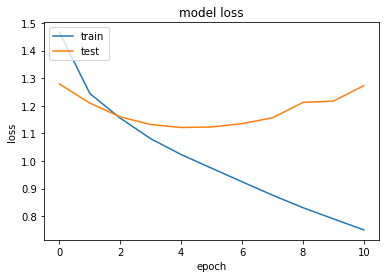

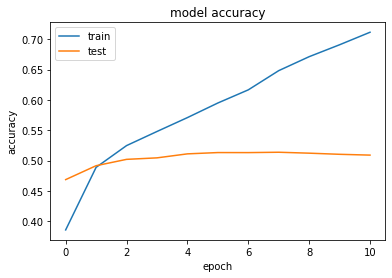

In [ ]:
early_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
base_model_3_4 = "https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2"
hub_layer = hub.KerasLayer(base_model_3_4, input_shape=[], dtype=tf.string, trainable=True)
model_3_4 = tf.keras.Sequential()
model_3_4.add(hub_layer)
model_3_4.add(tf.keras.layers.Dense(1024, activation='tanh'))
model_3_4.add(tf.keras.layers.Dense(256, activation='relu'))
model_3_4.add(tf.keras.layers.Dense(64, activation='tanh'))
model_3_4.add(tf.keras.layers.Dense(16, activation='relu'))
model_3_4.add(tf.keras.layers.Dense(6,activation="softmax"))
model_3_4.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.losses.CategoricalCrossentropy(from_logits=True),
              metrics=["accuracy"])
x_train=text_df_10[:75000]
y_train=stars_df_10[:75000]
x_val=text_df_10[75000:90000]
y_val=stars_df_10[75000:90000]
history_3_4 = model_3_4.fit(x_train,
                    y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1,
                    callbacks=[early_callback])
plt.plot(history_3_4.history['loss'])
plt.plot(history_3_4.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.plot(history_3_4.history['accuracy'])
plt.plot(history_3_4.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Intermidiate Conclusions:

It seems that out of all the tested models the most effective turned out to be a simpler model. As such the next experiments will be based off of that model.

### Further Tuning 

#### Attempt 1

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


147/147 [==============================] - ETA: 0s - loss: 1.6937 - accuracy: 0.2745

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


147/147 [==============================] - 206s 1s/step - loss: 1.6937 - accuracy: 0.2745 - val_loss: 1.5804 - val_accuracy: 0.3093
Epoch 2/20
147/147 [==============================] - 204s 1s/step - loss: 1.5498 - accuracy: 0.3378 - val_loss: 1.4858 - val_accuracy: 0.3565
Epoch 3/20
147/147 [==============================] - 205s 1s/step - loss: 1.4726 - accuracy: 0.4072 - val_loss: 1.4192 - val_accuracy: 0.4108
Epoch 4/20
147/147 [==============================] - 205s 1s/step - loss: 1.4066 - accuracy: 0.4433 - val_loss: 1.3607 - val_accuracy: 0.4383
Epoch 5/20
147/147 [==============================] - 206s 1s/step - loss: 1.3468 - accuracy: 0.4667 - val_loss: 1.3135 - val_accuracy: 0.4563
Epoch 6/20
147/147 [==============================] - 204s 1s/step - loss: 1.2944 - accuracy: 0.4955 - val_loss: 1.2738 - val_accuracy: 0.4753
Epoch 7/20
147/147 [==============================] - 205s 1s/step - loss: 1.2484 - accuracy: 0.5177 - val_loss: 1.2438 - val_accuracy: 0.4861
Epoch 8/20

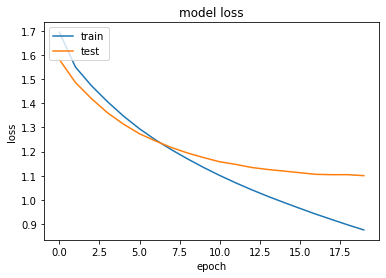

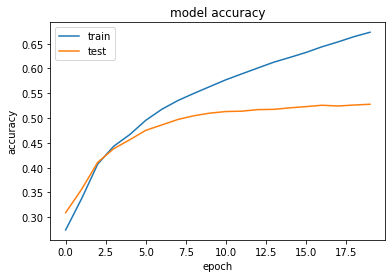

In [ ]:
early_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
base_model_3_1_1 = "https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2"
hub_layer = hub.KerasLayer(base_model_3_1_1, input_shape=[], dtype=tf.string, trainable=True)
model_3_1_1 = tf.keras.Sequential()
model_3_1_1.add(hub_layer)
model_3_1_1.add(tf.keras.layers.Dense(16, activation='relu'))
model_3_1_1.add(tf.keras.layers.Dense(6,activation="softmax"))
model_3_1_1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.losses.CategoricalCrossentropy(from_logits=True),
              metrics=["accuracy"])
x_train=text_df_10[:75000]
y_train=stars_df_10[:75000]
x_val=text_df_10[75000:90000]
y_val=stars_df_10[75000:90000]
history_3_1_1 = model_3_1_1.fit(x_train,
                    y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1,
                    callbacks=[early_callback])
plt.plot(history_3_1_1.history['loss'])
plt.plot(history_3_1_1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.plot(history_3_1_1.history['accuracy'])
plt.plot(history_3_1_1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### Attempt 2

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


147/147 [==============================] - ETA: 0s - loss: 1.5834 - accuracy: 0.3050

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


147/147 [==============================] - 204s 1s/step - loss: 1.5834 - accuracy: 0.3050 - val_loss: 1.4499 - val_accuracy: 0.3844
Epoch 2/20
147/147 [==============================] - 201s 1s/step - loss: 1.4418 - accuracy: 0.3928 - val_loss: 1.3914 - val_accuracy: 0.4283
Epoch 3/20
147/147 [==============================] - 201s 1s/step - loss: 1.3801 - accuracy: 0.4433 - val_loss: 1.3369 - val_accuracy: 0.4539
Epoch 4/20
147/147 [==============================] - 202s 1s/step - loss: 1.3160 - accuracy: 0.4771 - val_loss: 1.2821 - val_accuracy: 0.4732
Epoch 5/20
147/147 [==============================] - 201s 1s/step - loss: 1.2568 - accuracy: 0.4965 - val_loss: 1.2376 - val_accuracy: 0.4805
Epoch 6/20
147/147 [==============================] - 201s 1s/step - loss: 1.2063 - accuracy: 0.5119 - val_loss: 1.2013 - val_accuracy: 0.4913
Epoch 7/20
147/147 [==============================] - 203s 1s/step - loss: 1.1630 - accuracy: 0.5264 - val_loss: 1.1725 - val_accuracy: 0.4971
Epoch 8/20

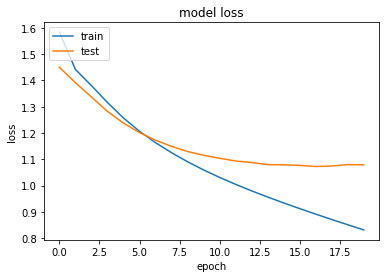

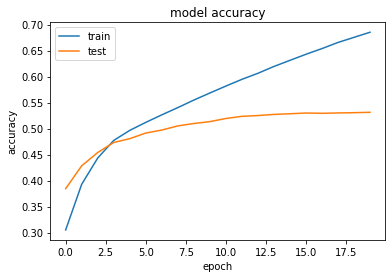

In [ ]:
early_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
base_model_3_1_2 = "https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2"
hub_layer = hub.KerasLayer(base_model_3_1_2, input_shape=[], dtype=tf.string, trainable=True)
model_3_1_2 = tf.keras.Sequential()
model_3_1_2.add(hub_layer)
model_3_1_2.add(tf.keras.layers.Dense(16, activation='tanh'))
model_3_1_2.add(tf.keras.layers.Dense(6,activation="softmax"))
model_3_1_2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.losses.CategoricalCrossentropy(from_logits=True),
              metrics=["accuracy"])
x_train=text_df_10[:75000]
y_train=stars_df_10[:75000]
x_val=text_df_10[75000:90000]
y_val=stars_df_10[75000:90000]
history_3_1_2 = model_3_1_2.fit(x_train,
                    y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1,
                    callbacks=[early_callback])
plt.plot(history_3_1_2.history['loss'])
plt.plot(history_3_1_2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.plot(history_3_1_2.history['accuracy'])
plt.plot(history_3_1_2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### Attempt 3

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


147/147 [==============================] - ETA: 0s - loss: 1.6050 - accuracy: 0.3295

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


147/147 [==============================] - 214s 1s/step - loss: 1.6050 - accuracy: 0.3295 - val_loss: 1.4729 - val_accuracy: 0.4013
Epoch 2/20
147/147 [==============================] - 207s 1s/step - loss: 1.4431 - accuracy: 0.4256 - val_loss: 1.3775 - val_accuracy: 0.4313
Epoch 3/20
147/147 [==============================] - 206s 1s/step - loss: 1.3647 - accuracy: 0.4515 - val_loss: 1.3221 - val_accuracy: 0.4436
Epoch 4/20
147/147 [==============================] - 206s 1s/step - loss: 1.3086 - accuracy: 0.4749 - val_loss: 1.2817 - val_accuracy: 0.4623
Epoch 5/20
147/147 [==============================] - 208s 1s/step - loss: 1.2618 - accuracy: 0.4954 - val_loss: 1.2495 - val_accuracy: 0.4743
Epoch 6/20
147/147 [==============================] - 213s 1s/step - loss: 1.2204 - accuracy: 0.5128 - val_loss: 1.2242 - val_accuracy: 0.4810
Epoch 7/20
147/147 [==============================] - 208s 1s/step - loss: 1.1834 - accuracy: 0.5276 - val_loss: 1.1982 - val_accuracy: 0.4932
Epoch 8/20

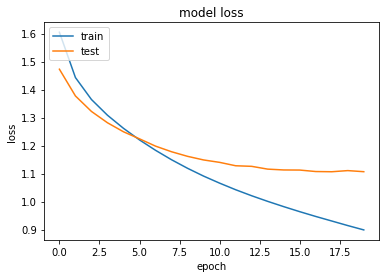

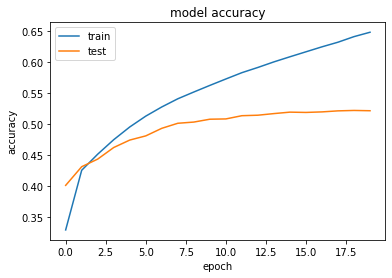

In [ ]:
early_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
base_model_3_1_3 = "https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2"
hub_layer = hub.KerasLayer(base_model_3_1_3, input_shape=[], dtype=tf.string, trainable=True)
model_3_1_3 = tf.keras.Sequential()
model_3_1_3.add(hub_layer)
model_3_1_3.add(tf.keras.layers.Dense(8, activation='relu'))
model_3_1_3.add(tf.keras.layers.Dense(6,activation="softmax"))
model_3_1_3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.losses.CategoricalCrossentropy(from_logits=True),
              metrics=["accuracy"])
x_train=text_df_10[:75000]
y_train=stars_df_10[:75000]
x_val=text_df_10[75000:90000]
y_val=stars_df_10[75000:90000]
history_3_1_3 = model_3_1_3.fit(x_train,
                    y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1,
                    callbacks=[early_callback])
plt.plot(history_3_1_3.history['loss'])
plt.plot(history_3_1_3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.plot(history_3_1_3.history['accuracy'])
plt.plot(history_3_1_3.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### Attempt 4

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


147/147 [==============================] - ETA: 0s - loss: 1.5567 - accuracy: 0.3391

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


147/147 [==============================] - 211s 1s/step - loss: 1.5567 - accuracy: 0.3391 - val_loss: 1.4490 - val_accuracy: 0.4027
Epoch 2/20
147/147 [==============================] - 223s 2s/step - loss: 1.4332 - accuracy: 0.4307 - val_loss: 1.3665 - val_accuracy: 0.4347
Epoch 3/20
147/147 [==============================] - 210s 1s/step - loss: 1.3415 - accuracy: 0.4628 - val_loss: 1.2875 - val_accuracy: 0.4627
Epoch 4/20
147/147 [==============================] - 208s 1s/step - loss: 1.2535 - accuracy: 0.4948 - val_loss: 1.2240 - val_accuracy: 0.4817
Epoch 5/20
147/147 [==============================] - 210s 1s/step - loss: 1.1813 - accuracy: 0.5182 - val_loss: 1.1756 - val_accuracy: 0.4943
Epoch 6/20
147/147 [==============================] - 208s 1s/step - loss: 1.1253 - accuracy: 0.5383 - val_loss: 1.1439 - val_accuracy: 0.5047
Epoch 7/20
147/147 [==============================] - 208s 1s/step - loss: 1.0786 - accuracy: 0.5571 - val_loss: 1.1249 - val_accuracy: 0.5087
Epoch 8/20

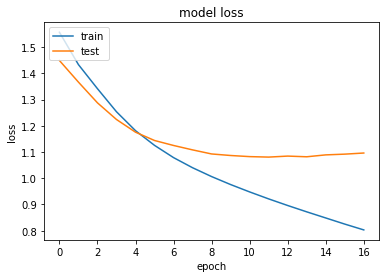

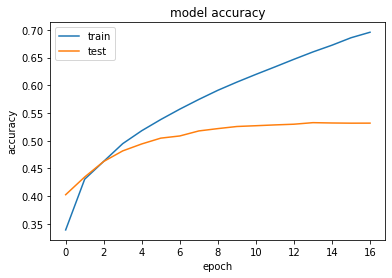

In [ ]:
early_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
base_model_3_1_4 = "https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2"
hub_layer = hub.KerasLayer(base_model_3_1_4, input_shape=[], dtype=tf.string, trainable=True)
model_3_1_4 = tf.keras.Sequential()
model_3_1_4.add(hub_layer)
model_3_1_4.add(tf.keras.layers.Dense(64, activation='relu'))
model_3_1_4.add(tf.keras.layers.Dense(6,activation="softmax"))
model_3_1_4.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.losses.CategoricalCrossentropy(from_logits=True),
              metrics=["accuracy"])
x_train=text_df_10[:75000]
y_train=stars_df_10[:75000]
x_val=text_df_10[75000:90000]
y_val=stars_df_10[75000:90000]
history_3_1_4 = model_3_1_4.fit(x_train,
                    y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1,
                    callbacks=[early_callback])
plt.plot(history_3_1_4.history['loss'])
plt.plot(history_3_1_4.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.plot(history_3_1_4.history['accuracy'])
plt.plot(history_3_1_4.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### Attempt 5

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


147/147 [==============================] - ETA: 0s - loss: 1.6179 - accuracy: 0.3207

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


147/147 [==============================] - 214s 1s/step - loss: 1.6179 - accuracy: 0.3207 - val_loss: 1.4830 - val_accuracy: 0.3727
Epoch 2/20
147/147 [==============================] - 219s 1s/step - loss: 1.4759 - accuracy: 0.4110 - val_loss: 1.4182 - val_accuracy: 0.4235
Epoch 3/20
147/147 [==============================] - 211s 1s/step - loss: 1.4183 - accuracy: 0.4554 - val_loss: 1.3720 - val_accuracy: 0.4545
Epoch 4/20
147/147 [==============================] - 212s 1s/step - loss: 1.3688 - accuracy: 0.4770 - val_loss: 1.3328 - val_accuracy: 0.4608
Epoch 5/20
147/147 [==============================] - 219s 1s/step - loss: 1.3225 - accuracy: 0.4948 - val_loss: 1.2965 - val_accuracy: 0.4726
Epoch 6/20
147/147 [==============================] - 217s 1s/step - loss: 1.2797 - accuracy: 0.5091 - val_loss: 1.2655 - val_accuracy: 0.4805
Epoch 7/20
147/147 [==============================] - 213s 1s/step - loss: 1.2407 - accuracy: 0.5204 - val_loss: 1.2372 - val_accuracy: 0.4865
Epoch 8/20

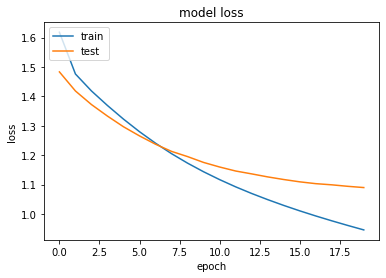

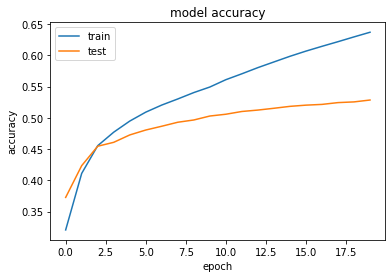

In [ ]:
early_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
base_model_3_1_5 = "https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2"
hub_layer = hub.KerasLayer(base_model_3_1_5, input_shape=[], dtype=tf.string, trainable=True)
model_3_1_5 = tf.keras.Sequential()
model_3_1_5.add(hub_layer)
model_3_1_5.add(tf.keras.layers.Dense(6,activation="softmax"))
model_3_1_5.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.losses.CategoricalCrossentropy(from_logits=True),
              metrics=["accuracy"])
x_train=text_df_10[:75000]
y_train=stars_df_10[:75000]
x_val=text_df_10[75000:90000]
y_val=stars_df_10[75000:90000]
history_3_1_5 = model_3_1_5.fit(x_train,
                    y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1,
                    callbacks=[early_callback])
plt.plot(history_3_1_5.history['loss'])
plt.plot(history_3_1_5.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.plot(history_3_1_5.history['accuracy'])
plt.plot(history_3_1_5.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### Attempt 6

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


147/147 [==============================] - ETA: 0s - loss: 1.5204 - accuracy: 0.3582

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


147/147 [==============================] - 222s 1s/step - loss: 1.5204 - accuracy: 0.3582 - val_loss: 1.4099 - val_accuracy: 0.4081
Epoch 2/20
147/147 [==============================] - 213s 1s/step - loss: 1.3840 - accuracy: 0.4371 - val_loss: 1.3240 - val_accuracy: 0.4467
Epoch 3/20
147/147 [==============================] - 212s 1s/step - loss: 1.2991 - accuracy: 0.4714 - val_loss: 1.2601 - val_accuracy: 0.4719
Epoch 4/20
147/147 [==============================] - 213s 1s/step - loss: 1.2302 - accuracy: 0.4983 - val_loss: 1.2118 - val_accuracy: 0.4869
Epoch 5/20
147/147 [==============================] - 213s 1s/step - loss: 1.1727 - accuracy: 0.5204 - val_loss: 1.1762 - val_accuracy: 0.4964
Epoch 6/20
147/147 [==============================] - 213s 1s/step - loss: 1.1230 - accuracy: 0.5397 - val_loss: 1.1485 - val_accuracy: 0.5042
Epoch 7/20
147/147 [==============================] - 214s 1s/step - loss: 1.0789 - accuracy: 0.5578 - val_loss: 1.1266 - val_accuracy: 0.5128
Epoch 8/20

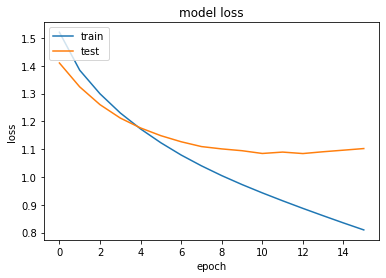

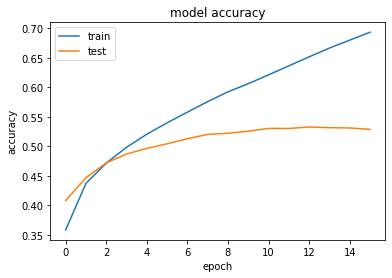

In [19]:
early_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
base_model_3_1_6 = "https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2"
hub_layer = hub.KerasLayer(base_model_3_1_6, input_shape=[], dtype=tf.string, trainable=True)
model_3_1_6 = tf.keras.Sequential()
model_3_1_6.add(hub_layer)
model_3_1_6.add(tf.keras.layers.Dense(64, activation='tanh'))
model_3_1_6.add(tf.keras.layers.Dense(6,activation="softmax"))
model_3_1_6.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.losses.CategoricalCrossentropy(from_logits=True),
              metrics=["accuracy"])
x_train=text_df_10[:75000]
y_train=stars_df_10[:75000]
x_val=text_df_10[75000:90000]
y_val=stars_df_10[75000:90000]
history_3_1_6 = model_3_1_6.fit(x_train,
                    y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1,
                    callbacks=[early_callback])
plt.plot(history_3_1_6.history['loss'])
plt.plot(history_3_1_6.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.plot(history_3_1_6.history['accuracy'])
plt.plot(history_3_1_6.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### Attempt 7

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


147/147 [==============================] - ETA: 0s - loss: 1.4634 - accuracy: 0.3966

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


147/147 [==============================] - 227s 1s/step - loss: 1.4634 - accuracy: 0.3966 - val_loss: 1.3480 - val_accuracy: 0.4414
Epoch 2/20
147/147 [==============================] - 222s 2s/step - loss: 1.2996 - accuracy: 0.4697 - val_loss: 1.2294 - val_accuracy: 0.4761
Epoch 3/20
147/147 [==============================] - 233s 2s/step - loss: 1.1898 - accuracy: 0.5038 - val_loss: 1.1638 - val_accuracy: 0.4957
Epoch 4/20
147/147 [==============================] - 218s 1s/step - loss: 1.1159 - accuracy: 0.5323 - val_loss: 1.1241 - val_accuracy: 0.5074
Epoch 5/20
147/147 [==============================] - 214s 1s/step - loss: 1.0619 - accuracy: 0.5553 - val_loss: 1.1076 - val_accuracy: 0.5112
Epoch 6/20
147/147 [==============================] - 213s 1s/step - loss: 1.0179 - accuracy: 0.5755 - val_loss: 1.0948 - val_accuracy: 0.5193
Epoch 7/20
147/147 [==============================] - 216s 1s/step - loss: 0.9803 - accuracy: 0.5947 - val_loss: 1.0949 - val_accuracy: 0.5213
Epoch 8/20

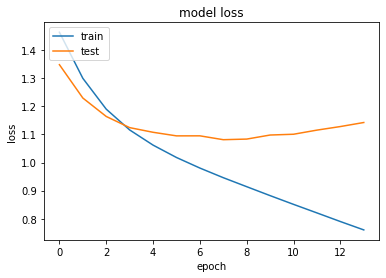

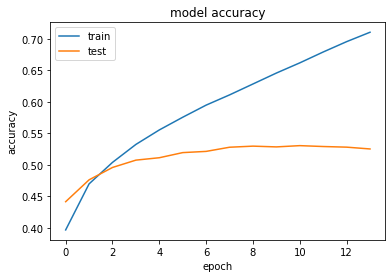

In [20]:
early_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
base_model_3_1_7 = "https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2"
hub_layer = hub.KerasLayer(base_model_3_1_7, input_shape=[], dtype=tf.string, trainable=True)
model_3_1_7 = tf.keras.Sequential()
model_3_1_7.add(hub_layer)
model_3_1_7.add(tf.keras.layers.Dense(512, activation='tanh'))
model_3_1_7.add(tf.keras.layers.Dense(6,activation="softmax"))
model_3_1_7.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.losses.CategoricalCrossentropy(from_logits=True),
              metrics=["accuracy"])
x_train=text_df_10[:75000]
y_train=stars_df_10[:75000]
x_val=text_df_10[75000:90000]
y_val=stars_df_10[75000:90000]
history_3_1_7 = model_3_1_7.fit(x_train,
                    y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1,
                    callbacks=[early_callback])
plt.plot(history_3_1_7.history['loss'])
plt.plot(history_3_1_7.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.plot(history_3_1_7.history['accuracy'])
plt.plot(history_3_1_7.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### Attempt 8

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


147/147 [==============================] - ETA: 0s - loss: 1.7073 - accuracy: 0.2819

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


147/147 [==============================] - 284s 2s/step - loss: 1.7073 - accuracy: 0.2819 - val_loss: 1.6149 - val_accuracy: 0.4030
Epoch 2/20
147/147 [==============================] - 303s 2s/step - loss: 1.5739 - accuracy: 0.4123 - val_loss: 1.5239 - val_accuracy: 0.4301
Epoch 3/20
147/147 [==============================] - 304s 2s/step - loss: 1.4963 - accuracy: 0.4455 - val_loss: 1.4636 - val_accuracy: 0.4476
Epoch 4/20
147/147 [==============================] - 309s 2s/step - loss: 1.4387 - accuracy: 0.4627 - val_loss: 1.4169 - val_accuracy: 0.4512
Epoch 5/20
147/147 [==============================] - 304s 2s/step - loss: 1.3891 - accuracy: 0.4801 - val_loss: 1.3752 - val_accuracy: 0.4589
Epoch 6/20
147/147 [==============================] - 310s 2s/step - loss: 1.3447 - accuracy: 0.4962 - val_loss: 1.3398 - val_accuracy: 0.4733
Epoch 7/20
147/147 [==============================] - 306s 2s/step - loss: 1.3054 - accuracy: 0.5112 - val_loss: 1.3090 - val_accuracy: 0.4820
Epoch 8/20

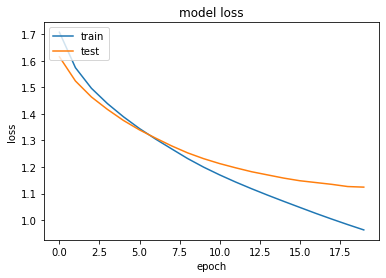

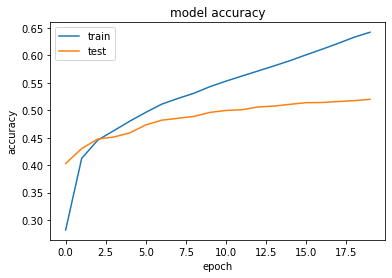

In [21]:
early_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
base_model_3_1_8 = "https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2"
hub_layer = hub.KerasLayer(base_model_3_1_8, input_shape=[], dtype=tf.string, trainable=True)
model_3_1_8 = tf.keras.Sequential()
model_3_1_8.add(hub_layer)
model_3_1_8.add(tf.keras.layers.Dense(8, activation='tanh'))
model_3_1_8.add(tf.keras.layers.Dense(6,activation="softmax"))
model_3_1_8.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.losses.CategoricalCrossentropy(from_logits=True),
              metrics=["accuracy"])
x_train=text_df_10[:75000]
y_train=stars_df_10[:75000]
x_val=text_df_10[75000:90000]
y_val=stars_df_10[75000:90000]
history_3_1_8 = model_3_1_8.fit(x_train,
                    y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1,
                    callbacks=[early_callback])
plt.plot(history_3_1_8.history['loss'])
plt.plot(history_3_1_8.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.plot(history_3_1_8.history['accuracy'])
plt.plot(history_3_1_8.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Intermidate Conclusions

Best Models seem to be model_3_1_6 and model_3_1_4, as such in further experiments model_3_1_4 will be used. Firstly best learning rte will be found and then the model will be trained on the whole dataset.

### Finding the best learning rate for model_3_1_4

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


147/147 [==============================] - ETA: 0s - loss: 1.5873 - accuracy: 0.3371

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


147/147 [==============================] - 214s 1s/step - loss: 1.5873 - accuracy: 0.3371 - val_loss: 1.4493 - val_accuracy: 0.4052 - lr: 1.0000e-04
Epoch 2/20
147/147 [==============================] - 213s 1s/step - loss: 1.4359 - accuracy: 0.4250 - val_loss: 1.3683 - val_accuracy: 0.4370 - lr: 1.1220e-04
Epoch 3/20
147/147 [==============================] - 218s 1s/step - loss: 1.3410 - accuracy: 0.4624 - val_loss: 1.2781 - val_accuracy: 0.4650 - lr: 1.2589e-04
Epoch 4/20
147/147 [==============================] - 221s 2s/step - loss: 1.2378 - accuracy: 0.4988 - val_loss: 1.1989 - val_accuracy: 0.4907 - lr: 1.4125e-04
Epoch 5/20
147/147 [==============================] - 213s 1s/step - loss: 1.1482 - accuracy: 0.5306 - val_loss: 1.1445 - val_accuracy: 0.5067 - lr: 1.5849e-04
Epoch 6/20
147/147 [==============================] - 212s 1s/step - loss: 1.0737 - accuracy: 0.5608 - val_loss: 1.1111 - val_accuracy: 0.5165 - lr: 1.7783e-04
Epoch 7/20
147/147 [==============================]

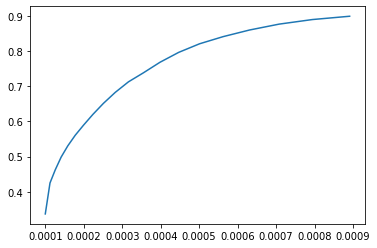

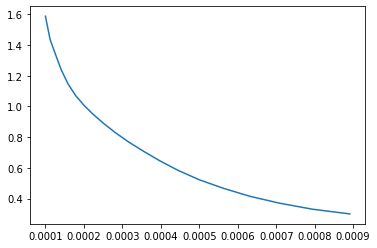

In [16]:
base_model = "https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2"
hub_layer = hub.KerasLayer(base_model, input_shape=[], dtype=tf.string, trainable=True)
model_lr = tf.keras.Sequential()
model_lr.add(hub_layer)
model_lr.add(tf.keras.layers.Dense(64, activation='relu'))
model_lr.add(tf.keras.layers.Dense(6,activation="softmax"))
model_lr.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.losses.CategoricalCrossentropy(from_logits=True),
              metrics=["accuracy"])
x_train=text_df_10[:75000]
y_train=stars_df_10[:75000]
x_val=text_df_10[75000:90000]
y_val=stars_df_10[75000:90000]
lr_scheduler=tf.keras.callbacks.LearningRateScheduler(lambda epoch:1e-4*10**(epoch/20))
history_lr = model_lr.fit(x_train,
                    y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1,
                    callbacks=[lr_scheduler])
lr=pd.DataFrame(history_lr.history)["lr"]
acc=pd.DataFrame(history_lr.history)["accuracy"]
loss=pd.DataFrame(history_lr.history)["loss"]
plt.plot(lr,acc);
plt.show()
plt.plot(lr,loss);
plt.show()

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


147/147 [==============================] - ETA: 0s - loss: 1.3050 - accuracy: 0.4603

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


147/147 [==============================] - 16s 85ms/step - loss: 1.3050 - accuracy: 0.4603 - val_loss: 1.1118 - val_accuracy: 0.5168
Epoch 2/20
147/147 [==============================] - 12s 82ms/step - loss: 0.9965 - accuracy: 0.5877 - val_loss: 1.0718 - val_accuracy: 0.5335
Epoch 3/20
147/147 [==============================] - 12s 82ms/step - loss: 0.8429 - accuracy: 0.6663 - val_loss: 1.1265 - val_accuracy: 0.5281
Epoch 4/20
147/147 [==============================] - 12s 82ms/step - loss: 0.7058 - accuracy: 0.7337 - val_loss: 1.2044 - val_accuracy: 0.5144
Epoch 5/20
147/147 [==============================] - 12s 82ms/step - loss: 0.5822 - accuracy: 0.7887 - val_loss: 1.3540 - val_accuracy: 0.5013


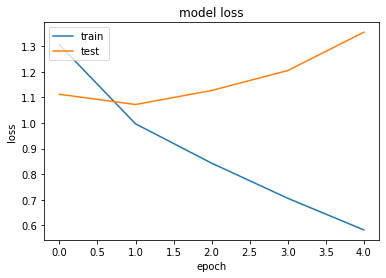

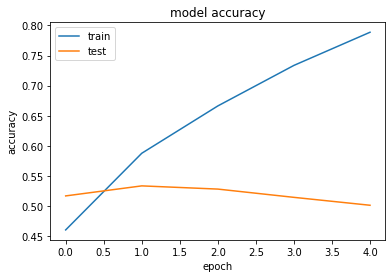

In [18]:
early_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
base_model_3_1_4 = "https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2"
hub_layer = hub.KerasLayer(base_model_3_1_4, input_shape=[], dtype=tf.string, trainable=True)
model_3_1_4 = tf.keras.Sequential()
model_3_1_4.add(hub_layer)
model_3_1_4.add(tf.keras.layers.Dense(64, activation='relu'))
model_3_1_4.add(tf.keras.layers.Dense(6,activation="softmax"))
model_3_1_4.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.losses.CategoricalCrossentropy(from_logits=True),
              metrics=["accuracy"])
x_train=text_df_10[:75000]
y_train=stars_df_10[:75000]
x_val=text_df_10[75000:90000]
y_val=stars_df_10[75000:90000]
history_3_1_4 = model_3_1_4.fit(x_train,
                    y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1,
                    callbacks=[early_callback])
plt.plot(history_3_1_4.history['loss'])
plt.plot(history_3_1_4.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.plot(history_3_1_4.history['accuracy'])
plt.plot(history_3_1_4.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


147/147 [==============================] - ETA: 0s - loss: 1.1290 - accuracy: 0.5176

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


147/147 [==============================] - 13s 85ms/step - loss: 1.1290 - accuracy: 0.5176 - val_loss: 1.0706 - val_accuracy: 0.5325
Epoch 2/20
147/147 [==============================] - 12s 83ms/step - loss: 0.8172 - accuracy: 0.6609 - val_loss: 1.1837 - val_accuracy: 0.5173
Epoch 3/20
147/147 [==============================] - 12s 83ms/step - loss: 0.5492 - accuracy: 0.7821 - val_loss: 1.4785 - val_accuracy: 0.4961
Epoch 4/20
147/147 [==============================] - 12s 83ms/step - loss: 0.3279 - accuracy: 0.8773 - val_loss: 2.0480 - val_accuracy: 0.4748


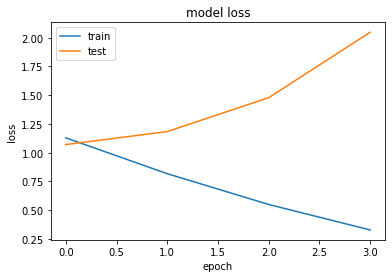

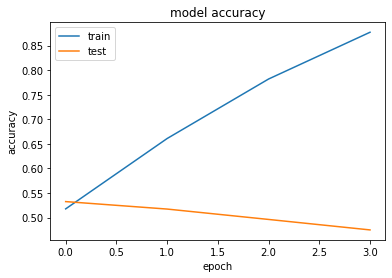

In [19]:
early_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
base_model_3_1_4 = "https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2"
hub_layer = hub.KerasLayer(base_model_3_1_4, input_shape=[], dtype=tf.string, trainable=True)
model_3_1_4 = tf.keras.Sequential()
model_3_1_4.add(hub_layer)
model_3_1_4.add(tf.keras.layers.Dense(64, activation='relu'))
model_3_1_4.add(tf.keras.layers.Dense(6,activation="softmax"))
model_3_1_4.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              loss=tf.losses.CategoricalCrossentropy(from_logits=True),
              metrics=["accuracy"])
x_train=text_df_10[:75000]
y_train=stars_df_10[:75000]
x_val=text_df_10[75000:90000]
y_val=stars_df_10[75000:90000]
history_3_1_4 = model_3_1_4.fit(x_train,
                    y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1,
                    callbacks=[early_callback])
plt.plot(history_3_1_4.history['loss'])
plt.plot(history_3_1_4.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.plot(history_3_1_4.history['accuracy'])
plt.plot(history_3_1_4.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


147/147 [==============================] - ETA: 0s - loss: 2.2835 - accuracy: 0.3419

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


147/147 [==============================] - 13s 86ms/step - loss: 2.2835 - accuracy: 0.3419 - val_loss: 1.4794 - val_accuracy: 0.3661
Epoch 2/20
147/147 [==============================] - 12s 83ms/step - loss: 1.5888 - accuracy: 0.3519 - val_loss: 1.4693 - val_accuracy: 0.3671
Epoch 3/20
147/147 [==============================] - 12s 83ms/step - loss: 1.5215 - accuracy: 0.3531 - val_loss: 1.4723 - val_accuracy: 0.3664
Epoch 4/20
147/147 [==============================] - 12s 83ms/step - loss: 1.4930 - accuracy: 0.3528 - val_loss: 1.5785 - val_accuracy: 0.3669
Epoch 5/20
147/147 [==============================] - 12s 84ms/step - loss: 1.4807 - accuracy: 0.3535 - val_loss: 1.5136 - val_accuracy: 0.3673
Epoch 6/20
147/147 [==============================] - 12s 83ms/step - loss: 1.4627 - accuracy: 0.3571 - val_loss: 1.5812 - val_accuracy: 0.3671
Epoch 7/20
147/147 [==============================] - 12s 83ms/step - loss: 1.6533 - accuracy: 0.3509 - val_loss: 1.9258 - val_accuracy: 0.3662
Epo

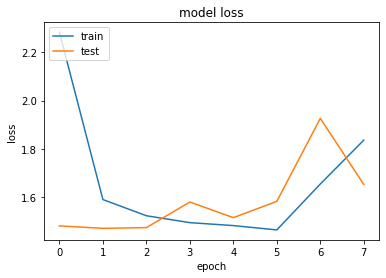

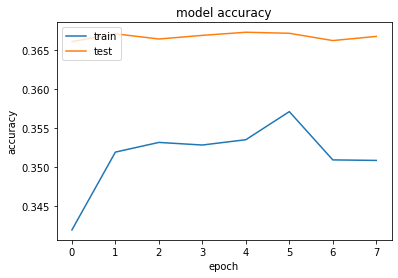

In [20]:
early_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
base_model_3_1_4 = "https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2"
hub_layer = hub.KerasLayer(base_model_3_1_4, input_shape=[], dtype=tf.string, trainable=True)
model_3_1_4 = tf.keras.Sequential()
model_3_1_4.add(hub_layer)
model_3_1_4.add(tf.keras.layers.Dense(64, activation='relu'))
model_3_1_4.add(tf.keras.layers.Dense(6,activation="softmax"))
model_3_1_4.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
              loss=tf.losses.CategoricalCrossentropy(from_logits=True),
              metrics=["accuracy"])
x_train=text_df_10[:75000]
y_train=stars_df_10[:75000]
x_val=text_df_10[75000:90000]
y_val=stars_df_10[75000:90000]
history_3_1_4 = model_3_1_4.fit(x_train,
                    y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1,
                    callbacks=[early_callback])
plt.plot(history_3_1_4.history['loss'])
plt.plot(history_3_1_4.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.plot(history_3_1_4.history['accuracy'])
plt.plot(history_3_1_4.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


147/147 [==============================] - ETA: 0s - loss: 1.4529 - accuracy: 0.4094

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


147/147 [==============================] - 15s 98ms/step - loss: 1.4529 - accuracy: 0.4094 - val_loss: 1.2861 - val_accuracy: 0.4670
Epoch 2/20
147/147 [==============================] - 13s 88ms/step - loss: 1.2027 - accuracy: 0.5021 - val_loss: 1.1393 - val_accuracy: 0.5055
Epoch 3/20
147/147 [==============================] - 12s 83ms/step - loss: 1.0630 - accuracy: 0.5574 - val_loss: 1.0842 - val_accuracy: 0.5237
Epoch 4/20
147/147 [==============================] - 12s 83ms/step - loss: 0.9793 - accuracy: 0.5972 - val_loss: 1.0743 - val_accuracy: 0.5289
Epoch 5/20
147/147 [==============================] - 12s 84ms/step - loss: 0.9108 - accuracy: 0.6335 - val_loss: 1.0809 - val_accuracy: 0.5287
Epoch 6/20
147/147 [==============================] - 12s 84ms/step - loss: 0.8482 - accuracy: 0.6676 - val_loss: 1.0912 - val_accuracy: 0.5300
Epoch 7/20
147/147 [==============================] - 12s 84ms/step - loss: 0.7872 - accuracy: 0.7003 - val_loss: 1.1122 - val_accuracy: 0.5257
Epo

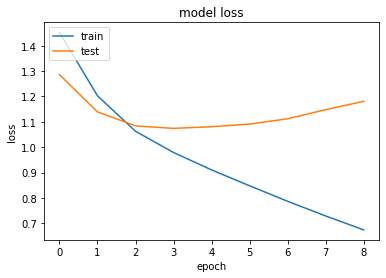

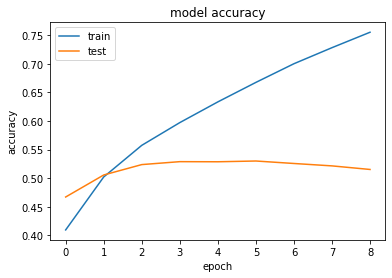

In [21]:
early_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
base_model_3_1_4 = "https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2"
hub_layer = hub.KerasLayer(base_model_3_1_4, input_shape=[], dtype=tf.string, trainable=True)
model_3_1_4 = tf.keras.Sequential()
model_3_1_4.add(hub_layer)
model_3_1_4.add(tf.keras.layers.Dense(64, activation='relu'))
model_3_1_4.add(tf.keras.layers.Dense(6,activation="softmax"))
model_3_1_4.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
              loss=tf.losses.CategoricalCrossentropy(from_logits=True),
              metrics=["accuracy"])
x_train=text_df_10[:75000]
y_train=stars_df_10[:75000]
x_val=text_df_10[75000:90000]
y_val=stars_df_10[75000:90000]
history_3_1_4 = model_3_1_4.fit(x_train,
                    y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1,
                    callbacks=[early_callback])
plt.plot(history_3_1_4.history['loss'])
plt.plot(history_3_1_4.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.plot(history_3_1_4.history['accuracy'])
plt.plot(history_3_1_4.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Fitting the Final Model on All the Data

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


1563/1563 [==============================] - ETA: 0s - loss: 1.2550 - accuracy: 0.4764

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


1563/1563 [==============================] - 144s 90ms/step - loss: 1.2550 - accuracy: 0.4764 - val_loss: 1.0870 - val_accuracy: 0.5359
Epoch 2/20
1563/1563 [==============================] - 140s 89ms/step - loss: 1.0578 - accuracy: 0.5502 - val_loss: 1.0415 - val_accuracy: 0.5564
Epoch 3/20
1563/1563 [==============================] - 146s 93ms/step - loss: 1.0161 - accuracy: 0.5706 - val_loss: 1.0285 - val_accuracy: 0.5630
Epoch 4/20
1563/1563 [==============================] - 145s 93ms/step - loss: 0.9915 - accuracy: 0.5826 - val_loss: 1.0223 - val_accuracy: 0.5660
Epoch 5/20
1563/1563 [==============================] - 137s 88ms/step - loss: 0.9728 - accuracy: 0.5922 - val_loss: 1.0226 - val_accuracy: 0.5651
Epoch 6/20
1563/1563 [==============================] - 131s 84ms/step - loss: 0.9568 - accuracy: 0.6002 - val_loss: 1.0245 - val_accuracy: 0.5649
Epoch 7/20
1563/1563 [==============================] - 130s 83ms/step - loss: 0.9420 - accuracy: 0.6081 - val_loss: 1.0289 - val

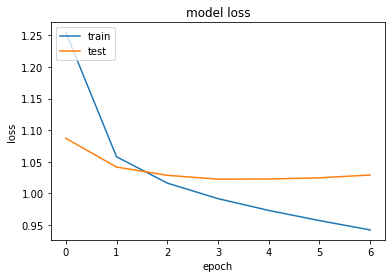

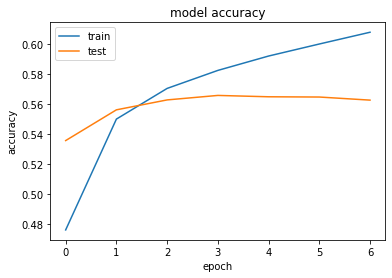

In [19]:
model_checkpoint=tf.keras.callbacks.ModelCheckpoint(
    '/content/drive/MyDrive/GoodReviews_NN/model',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
)
early_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
base_model = "https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2"
hub_layer = hub.KerasLayer(base_model, input_shape=[], dtype=tf.string, trainable=True)
model_fin = tf.keras.Sequential()
model_fin.add(hub_layer)
model_fin.add(tf.keras.layers.Dense(64, activation='relu'))
model_fin.add(tf.keras.layers.Dense(6,activation="softmax"))
model_fin.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.losses.CategoricalCrossentropy(from_logits=True),
              metrics=["accuracy"])
x_train=text_df[:800000]
y_train=stars_df[:800000]
x_val=text_df[800000:]
y_val=stars_df[800000:]
history_fin = model_fin.fit(x_train,
                    y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1,
                    callbacks=[early_callback,model_checkpoint])
plt.plot(history_fin.history['loss'])
plt.plot(history_fin.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.plot(history_fin.history['accuracy'])
plt.plot(history_fin.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Loading a Model and Performing Evaluations on Test Data

In [20]:
fin_model=tf.keras.models.load_model('/content/drive/MyDrive/GoodReviews_NN/model')

In [21]:
test_df=pd.read_csv("/content/drive/MyDrive/GoodReviews_NN/goodreads_test.csv")

In [23]:
text_test=test_df["review_text"]

In [25]:
ans=fin_model.predict(text_test)

In [30]:
ratings=[0,1,2,3,4,5]
sols=[]
for i in range(len(ans)):
  sols.append(ratings[ans[i].argmax()])

In [36]:
ans_df=pd.DataFrame()
ans_df["review_id"]=test_df["review_id"]
ans_df["rating"]=sols
ans_df

,review_id,rating
0,5c4df7e70e9b438c761f07a4620ccb7c,4
1,8eaeaf13213eeb16ad879a2a2591bbe5,4
2,dce649b733c153ba5363a0413cac988f,5
3,8a46df0bb997269d6834f9437a4b0a77,4
4,d11d3091e22f1cf3cb865598de197599,4
...,...,...
478028,0e1db3d4b04256f9660f5d276ddf1314,5
478029,0b7f352e58caf0fd1f961e98ef04e89c,5
478030,9b19eff33ddb14e9e68fca2e90379e46,5
478031,8be463fed78f0da63e964706f710332b,4


In [42]:
ans_df.to_csv("Solution.csv", index=False)

# Binary Sentiment Analysis

### Data Import and Analysis

In [43]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential
import tensorflow_text as text
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
from official.nlp import optimization
import shutil
import random
import numpy as np
import pandas as pd
import tensorflow_hub as hub
import tensorflow_datasets as tfds
tf.get_logger().setLevel('ERROR')

In [44]:
reviews_df=pd.read_csv("/content/drive/MyDrive/GoodReviews_NN/goodreads_train.csv")

In [45]:
text_df=reviews_df["review_text"]

In [46]:
stars_df=reviews_df["rating"]

In [47]:
for i,j in stars_df.items():
  if j>=3:
    stars_df[i]=1
  else:
    stars_df[i]=0
stars_df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


0         1
1         1
2         1
3         0
4         1
         ..
899995    1
899996    1
899997    1
899998    1
899999    1
Name: rating, Length: 900000, dtype: int64

In [49]:
text_df_10=text_df[:90000]
stars_df_10=stars_df[:90000]

### Fitting the Models

#### Attempt 1

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


147/147 [==============================] - 14s 84ms/step - loss: 0.4808 - accuracy: 0.8576 - val_loss: 0.4108 - val_accuracy: 0.8687
Epoch 2/20
147/147 [==============================] - 13s 87ms/step - loss: 0.4245 - accuracy: 0.8609 - val_loss: 0.3858 - val_accuracy: 0.8689
Epoch 3/20
147/147 [==============================] - 12s 84ms/step - loss: 0.3956 - accuracy: 0.8612 - val_loss: 0.3591 - val_accuracy: 0.8691
Epoch 4/20
147/147 [==============================] - 12s 84ms/step - loss: 0.3640 - accuracy: 0.8617 - val_loss: 0.3317 - val_accuracy: 0.8699
Epoch 5/20
147/147 [==============================] - 12s 83ms/step - loss: 0.3330 - accuracy: 0.8637 - val_loss: 0.3059 - val_accuracy: 0.8752
Epoch 6/20
147/147 [==============================] - 12s 83ms/step - loss: 0.3040 - accuracy: 0.8756 - val_loss: 0.2847 - val_accuracy: 0.8838
Epoch 7/20
147/147 [==============================] - 13s 87ms/step - loss: 0.2781 - accuracy: 0.8900 - val_loss: 0.2671 - val_accuracy: 0.8908
Epo

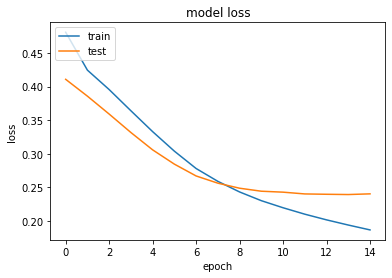

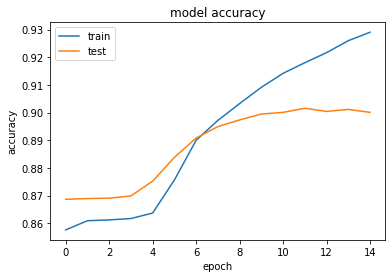

In [50]:
early_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
base_model = "https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2"
hub_layer = hub.KerasLayer(base_model, input_shape=[], dtype=tf.string, trainable=True)
model_1 = tf.keras.Sequential()
model_1.add(hub_layer)
model_1.add(tf.keras.layers.Dense(16, activation='relu'))
model_1.add(tf.keras.layers.Dense(1,activation="sigmoid"))
model_1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=["accuracy"])
x_train=text_df_10[:75000]
y_train=stars_df_10[:75000]
x_val=text_df_10[75000:]
y_val=stars_df_10[75000:]
history_1 = model_1.fit(x_train,
                    y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1,
                    callbacks=[early_callback])
plt.plot(history_1.history['loss'])
plt.plot(history_1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### Attempt 2

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


147/147 [==============================] - 13s 88ms/step - loss: 0.4639 - accuracy: 0.8465 - val_loss: 0.3925 - val_accuracy: 0.8689
Epoch 2/20
147/147 [==============================] - 13s 86ms/step - loss: 0.4020 - accuracy: 0.8615 - val_loss: 0.3679 - val_accuracy: 0.8694
Epoch 3/20
147/147 [==============================] - 12s 83ms/step - loss: 0.3724 - accuracy: 0.8625 - val_loss: 0.3403 - val_accuracy: 0.8717
Epoch 4/20
147/147 [==============================] - 12s 83ms/step - loss: 0.3389 - accuracy: 0.8658 - val_loss: 0.3108 - val_accuracy: 0.8756
Epoch 5/20
147/147 [==============================] - 12s 84ms/step - loss: 0.3058 - accuracy: 0.8747 - val_loss: 0.2851 - val_accuracy: 0.8826
Epoch 6/20
147/147 [==============================] - 12s 84ms/step - loss: 0.2790 - accuracy: 0.8873 - val_loss: 0.2675 - val_accuracy: 0.8895
Epoch 7/20
147/147 [==============================] - 12s 84ms/step - loss: 0.2588 - accuracy: 0.8970 - val_loss: 0.2559 - val_accuracy: 0.8939
Epo

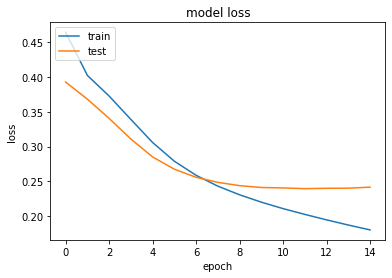

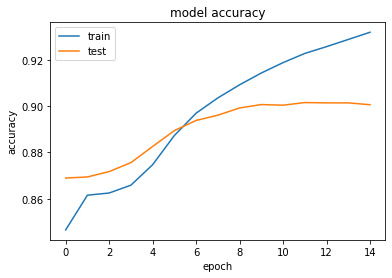

In [51]:
early_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
base_model_2 = "https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2"
hub_layer = hub.KerasLayer(base_model_2, input_shape=[], dtype=tf.string, trainable=True)
model_2 = tf.keras.Sequential()
model_2.add(hub_layer)
model_2.add(tf.keras.layers.Dense(16, activation='tanh'))
model_2.add(tf.keras.layers.Dense(1,activation="sigmoid"))
model_2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=["accuracy"])
x_train=text_df_10[:75000]
y_train=stars_df_10[:75000]
x_val=text_df_10[75000:]
y_val=stars_df_10[75000:]
history_2 = model_2.fit(x_train,
                    y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1,
                    callbacks=[early_callback])
plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.plot(history_2.history['accuracy'])
plt.plot(history_2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### Attempt 3

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


147/147 [==============================] - 13s 86ms/step - loss: 0.4642 - accuracy: 0.8604 - val_loss: 0.4015 - val_accuracy: 0.8686
Epoch 2/20
147/147 [==============================] - 14s 93ms/step - loss: 0.4063 - accuracy: 0.8611 - val_loss: 0.3594 - val_accuracy: 0.8687
Epoch 3/20
147/147 [==============================] - 13s 91ms/step - loss: 0.3557 - accuracy: 0.8619 - val_loss: 0.3129 - val_accuracy: 0.8721
Epoch 4/20
147/147 [==============================] - 12s 82ms/step - loss: 0.3070 - accuracy: 0.8724 - val_loss: 0.2787 - val_accuracy: 0.8855
Epoch 5/20
147/147 [==============================] - 12s 83ms/step - loss: 0.2745 - accuracy: 0.8873 - val_loss: 0.2605 - val_accuracy: 0.8927
Epoch 6/20
147/147 [==============================] - 13s 90ms/step - loss: 0.2533 - accuracy: 0.8968 - val_loss: 0.2504 - val_accuracy: 0.8973
Epoch 7/20
147/147 [==============================] - 12s 83ms/step - loss: 0.2373 - accuracy: 0.9046 - val_loss: 0.2448 - val_accuracy: 0.8992
Epo

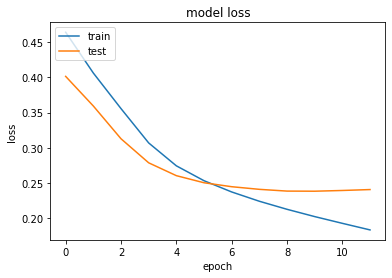

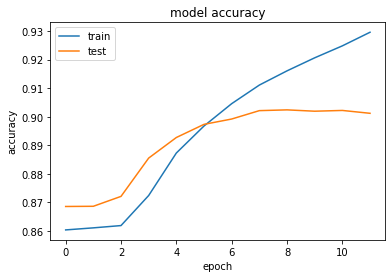

In [52]:
early_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
base_model_3 = "https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2"
hub_layer = hub.KerasLayer(base_model_3, input_shape=[], dtype=tf.string, trainable=True)
model_3 = tf.keras.Sequential()
model_3.add(hub_layer)
model_3.add(tf.keras.layers.Dense(64, activation='relu'))
model_3.add(tf.keras.layers.Dense(1,activation="sigmoid"))
model_3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=["accuracy"])
x_train=text_df_10[:75000]
y_train=stars_df_10[:75000]
x_val=text_df_10[75000:]
y_val=stars_df_10[75000:]
history_3 = model_3.fit(x_train,
                    y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1,
                    callbacks=[early_callback])
plt.plot(history_3.history['loss'])
plt.plot(history_3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.plot(history_3.history['accuracy'])
plt.plot(history_3.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


147/147 [==============================] - 16s 104ms/step - loss: 0.4437 - accuracy: 0.8595 - val_loss: 0.3859 - val_accuracy: 0.8687
Epoch 2/20
147/147 [==============================] - 14s 97ms/step - loss: 0.3868 - accuracy: 0.8613 - val_loss: 0.3475 - val_accuracy: 0.8681
Epoch 3/20
147/147 [==============================] - 12s 84ms/step - loss: 0.3410 - accuracy: 0.8638 - val_loss: 0.3063 - val_accuracy: 0.8743
Epoch 4/20
147/147 [==============================] - 12s 84ms/step - loss: 0.2980 - accuracy: 0.8751 - val_loss: 0.2745 - val_accuracy: 0.8844
Epoch 5/20
147/147 [==============================] - 13s 90ms/step - loss: 0.2668 - accuracy: 0.8907 - val_loss: 0.2566 - val_accuracy: 0.8925
Epoch 6/20
147/147 [==============================] - 15s 103ms/step - loss: 0.2461 - accuracy: 0.8999 - val_loss: 0.2474 - val_accuracy: 0.8984
Epoch 7/20
147/147 [==============================] - 12s 85ms/step - loss: 0.2309 - accuracy: 0.9077 - val_loss: 0.2429 - val_accuracy: 0.9000
E

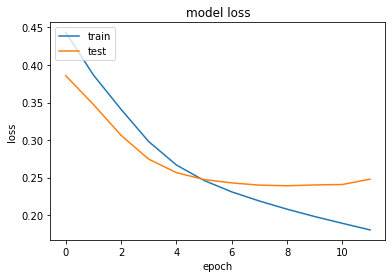

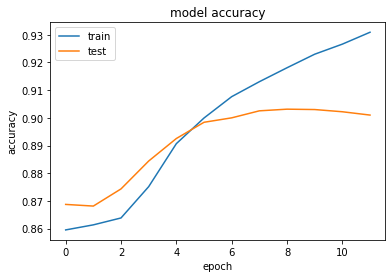

In [53]:
early_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
base_model_4 = "https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2"
hub_layer = hub.KerasLayer(base_model_4, input_shape=[], dtype=tf.string, trainable=True)
model_4 = tf.keras.Sequential()
model_4.add(hub_layer)
model_4.add(tf.keras.layers.Dense(64, activation='tanh'))
model_4.add(tf.keras.layers.Dense(1,activation="sigmoid"))
model_4.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=["accuracy"])
x_train=text_df_10[:75000]
y_train=stars_df_10[:75000]
x_val=text_df_10[75000:]
y_val=stars_df_10[75000:]
history_4 = model_4.fit(x_train,
                    y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1,
                    callbacks=[early_callback])
plt.plot(history_4.history['loss'])
plt.plot(history_4.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.plot(history_4.history['accuracy'])
plt.plot(history_4.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### Fitting the Final Model

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


1563/1563 [==============================] - 130s 83ms/step - loss: 0.3268 - accuracy: 0.8702 - val_loss: 0.2533 - val_accuracy: 0.9000
Epoch 2/20
1563/1563 [==============================] - 129s 83ms/step - loss: 0.2519 - accuracy: 0.8993 - val_loss: 0.2471 - val_accuracy: 0.9041
Epoch 3/20
1563/1563 [==============================] - 130s 83ms/step - loss: 0.2407 - accuracy: 0.9042 - val_loss: 0.2458 - val_accuracy: 0.9048
Epoch 4/20
1563/1563 [==============================] - 130s 83ms/step - loss: 0.2336 - accuracy: 0.9073 - val_loss: 0.2470 - val_accuracy: 0.9048
Epoch 5/20
1563/1563 [==============================] - 129s 83ms/step - loss: 0.2280 - accuracy: 0.9100 - val_loss: 0.2496 - val_accuracy: 0.9041
Epoch 6/20
1563/1563 [==============================] - 131s 84ms/step - loss: 0.2231 - accuracy: 0.9122 - val_loss: 0.2529 - val_accuracy: 0.9036


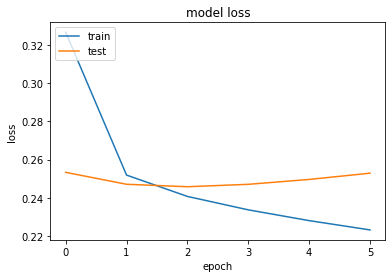

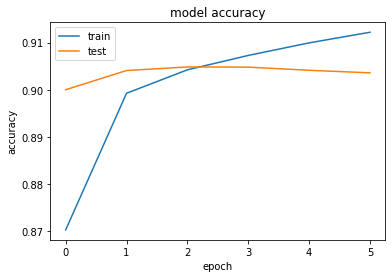

In [54]:
early_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
base_model_fin = "https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2"
hub_layer = hub.KerasLayer(base_model_fin, input_shape=[], dtype=tf.string, trainable=True)
model_fin = tf.keras.Sequential()
model_fin.add(hub_layer)
model_fin.add(tf.keras.layers.Dense(64, activation='tanh'))
model_fin.add(tf.keras.layers.Dense(1,activation="sigmoid"))
model_fin.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=["accuracy"])
x_train=text_df[:800000]
y_train=stars_df[:800000]
x_val=text_df[800000:]
y_val=stars_df[800000:]
history_fin = model_fin.fit(x_train,
                    y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1,
                    callbacks=[early_callback])
plt.plot(history_fin.history['loss'])
plt.plot(history_fin.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.plot(history_fin.history['accuracy'])
plt.plot(history_fin.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()